# Adversarial AE detection and correction on CIFAR-10

### Method


The adversarial detector is based on [Adversarial Detection and Correction by Matching Prediction Distributions](https://arxiv.org/abs/2002.09364). Usually, autoencoders are trained to find a transformation $T$ that reconstructs the input instance $x$ as accurately as possible with loss functions that are suited to capture the similarities between x and $x'$ such as the mean squared reconstruction error. The novelty of the adversarial autoencoder (AE) detector relies on the use of a classification model-dependent loss function based on a distance metric in the output space of the model to train the autoencoder network. Given a classification model $M$ we optimise the weights of the autoencoder such that the [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the model predictions on $x$ and on $x'$ is minimised. Without the presence of a reconstruction loss term $x'$ simply tries to make sure that the prediction probabilities $M(x')$ and $M(x)$ match without caring about the proximity of $x'$ to $x$. As a result, $x'$ is allowed to live in different areas of the input feature space than $x$ with different decision boundary shapes with respect to the model $M$. The carefully crafted adversarial perturbation which is effective around x does not transfer to the new location of $x'$ in the feature space, and the attack is therefore neutralised. Training of the autoencoder is unsupervised since we only need access to the model prediction probabilities and the normal training instances. We do not require any knowledge about the underlying adversarial attack and the classifier weights are frozen during training. 

The detector can be used as follows:

* An adversarial score $S$ is computed. $S$ equals the K-L divergence between the model predictions on $x$ and $x'$.

* If $S$ is above a threshold (explicitly defined or inferred from training data), the instance is flagged as adversarial.

* For adversarial instances, the model $M$ uses the reconstructed instance $x'$ to make a prediction. If the adversarial score is below the threshold, the model makes a prediction on the original instance $x$.

This procedure is illustrated in the diagram below:

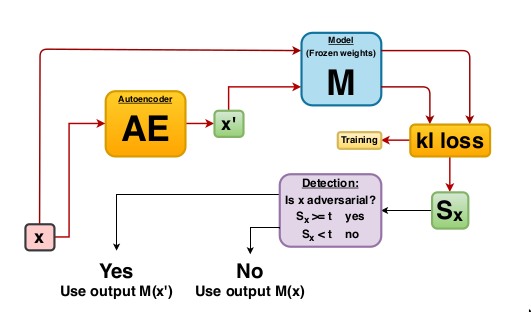

The method is very flexible and can also be used to detect common data corruptions and perturbations which negatively impact the model performance.

## Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes.

**Note**: in order to run this notebook, it is adviced to use **Python 3.7** and have a **GPU** enabled.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, Dense, Flatten, 
                                     InputLayer, Reshape)
from tensorflow.keras.regularizers import l1

from alibi_detect.ad import AdversarialAE
from alibi_detect.utils.fetching import fetch_detector, fetch_tf_model
from alibi_detect.utils.tensorflow.prediction import predict_batch
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_attack, fetch_cifar10c, corruption_types_cifar10c

### Utility functions

In [ ]:
def scale_by_instance(X: np.ndarray) -> np.ndarray:
    mean_ = X.mean(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
    std_ = X.std(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
    return (X - mean_) / std_, mean_, std_


def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (y_true == y_pred).astype(int).sum() / y_true.shape[0]


def plot_adversarial(idx: list,
                     X: np.ndarray,
                     y: np.ndarray,
                     X_adv: np.ndarray, 
                     y_adv: np.ndarray,
                     mean: np.ndarray, 
                     std: np.ndarray, 
                     score_x: np.ndarray = None,
                     score_x_adv: np.ndarray = None,
                     X_recon: np.ndarray = None,
                     y_recon: np.ndarray = None,
                     figsize: tuple = (10, 5)) -> None:
    
    # category map from class numbers to names
    cifar10_map = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                   6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
    
    nrows = len(idx)
    ncols = 3 if isinstance(X_recon, np.ndarray) else 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    n_subplot = 1
    for i in idx:
        
        # rescale images in [0, 1]
        X_adj = (X[i] * std[i] + mean[i]) / 255
        X_adv_adj = (X_adv[i] * std[i] + mean[i]) / 255
        if isinstance(X_recon, np.ndarray):
            X_recon_adj = (X_recon[i] * std[i] + mean[i]) / 255
        
        # original image
        plt.subplot(nrows, ncols, n_subplot)
        plt.axis('off')
        if i == idx[0]:
            if isinstance(score_x, np.ndarray):
                plt.title('CIFAR-10 Image \n{}: {:.3f}'.format(cifar10_map[y[i]], score_x[i]))
            else:
                plt.title('CIFAR-10 Image \n{}'.format(cifar10_map[y[i]]))
        else:
            if isinstance(score_x, np.ndarray):
                plt.title('{}: {:.3f}'.format(cifar10_map[y[i]], score_x[i]))
            else:
                plt.title('{}'.format(cifar10_map[y[i]]))
        plt.imshow(X_adj)
        n_subplot += 1
        
        # adversarial image
        plt.subplot(nrows, ncols, n_subplot)
        plt.axis('off')
        if i == idx[0]:
            if isinstance(score_x_adv, np.ndarray):
                plt.title('Adversarial \n{}: {:.3f}'.format(cifar10_map[y_adv[i]], score_x_adv[i]))
            else:
                plt.title('Adversarial \n{}'.format(cifar10_map[y_adv[i]]))
        else:
            if isinstance(score_x_adv, np.ndarray):
                plt.title('{}: {:.3f}'.format(cifar10_map[y_adv[i]], score_x_adv[i]))
            else:
                plt.title('{}'.format(cifar10_map[y_adv[i]]))
        plt.imshow(X_adv_adj)
        n_subplot += 1
     
        # reconstructed image
        if isinstance(X_recon, np.ndarray):
            plt.subplot(nrows, ncols, n_subplot)
            plt.axis('off')
            if i == idx[0]:
                plt.title('AE Reconstruction \n{}'.format(cifar10_map[y_recon[i]]))
            else:
                plt.title('{}'.format(cifar10_map[y_recon[i]]))
            plt.imshow(X_recon_adj)
            n_subplot += 1
    
    plt.show()

    
def plot_roc(roc_data: dict, figsize: tuple = (10,5)):
    plot_labels = []
    scores_attacks = []
    labels_attacks = []
    for k, v in roc_data.items():
        if 'original' in k:
            continue
        score_x = roc_data[v['normal']]['scores']
        y_pred = roc_data[v['normal']]['predictions']
        score_v = v['scores']
        y_pred_v = v['predictions']
        labels_v = np.ones(score_x.shape[0])
        idx_remove = np.where(y_pred == y_pred_v)[0]
        labels_v = np.delete(labels_v, idx_remove)
        score_v = np.delete(score_v, idx_remove)
        scores = np.concatenate([score_x, score_v])
        labels = np.concatenate([np.zeros(y_pred.shape[0]), labels_v]).astype(int)
        scores_attacks.append(scores)
        labels_attacks.append(labels)
        plot_labels.append(k)
    
    for sc_att, la_att, plt_la in zip(scores_attacks, labels_attacks, plot_labels):
        fpr, tpr, thresholds = roc_curve(la_att, sc_att)
        roc_auc = auc(fpr, tpr)
        label = str('{}: AUC = {:.2f}'.format(plt_la, roc_auc))
        plt.plot(fpr, tpr, lw=1, label='{}: AUC={:.4f}'.format(plt_la, roc_auc))

    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{}'.format('ROC curve'))
    plt.legend(loc="lower right", ncol=1)
    plt.grid()
    plt.show()

### Load data

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

Standardise the dataset by instance:

In [ ]:
X_train, mean_train, std_train = scale_by_instance(X_train)
X_test, mean_test, std_test = scale_by_instance(X_test)
scale = (mean_train, std_train), (mean_test, std_test)

### Load classifier

In [ ]:
dataset = 'cifar10'
model = 'resnet56'
clf = fetch_tf_model(dataset, model)

Check that the predictions on the test set reach $93.15$% accuracy:

In [ ]:
y_pred = predict_batch(clf, X_test, batch_size=32, return_class=True)
acc_y_pred = accuracy(y_test, y_pred)
print('Accuracy: {:.4f}'.format(acc_y_pred))

### Adversarial Attack

We investigate both [Carlini-Wagner (C&W)](https://arxiv.org/abs/1608.04644) and [SLIDE](https://arxiv.org/abs/1904.13000) attacks. You can simply load previously found adversarial instances on the pretrained ResNet-56 model. The attacks are generated by using [Foolbox](https://github.com/bethgelab/foolbox):

In [ ]:
# C&W attack
data_cw = fetch_attack(dataset, model, 'cw')
X_train_cw, X_test_cw = data_cw['data_train'], data_cw['data_test']
meta_cw = data_cw['meta'] # metadata with hyperparameters of the attack
# SLIDE attack
data_slide = fetch_attack(dataset, model, 'slide')
X_train_slide, X_test_slide = data_slide['data_train'], data_slide['data_test']
meta_slide = data_slide['meta']

In [ ]:
print(X_test_cw.shape, X_test_slide.shape)

Check if the prediction accuracy of the model on the adversarial instances is close to $0$%.

In [ ]:
y_pred_cw = predict_batch(clf, X_test_cw, batch_size=32, return_class=True)
y_pred_slide = predict_batch(clf, X_test_slide, batch_size=32, return_class=True)

In [ ]:
acc_y_pred_cw = accuracy(y_test, y_pred_cw)
acc_y_pred_slide = accuracy(y_test, y_pred_slide)
print('Accuracy: cw {:.4f} -- SLIDE {:.4f}'.format(acc_y_pred_cw, acc_y_pred_slide))

Let's visualise some adversarial instances:

In [ ]:
idx = [3, 4]
print('C&W attack...')
plot_adversarial(idx, X_test, y_pred, X_test_cw, y_pred_cw, 
                 mean_test, std_test, figsize=(10, 10))
print('SLIDE attack...')
plot_adversarial(idx, X_test, y_pred, X_test_slide, y_pred_slide, 
                 mean_test, std_test, figsize=(10, 10))

### Load or train and evaluate the adversarial detectors

We can again either fetch the pretrained detector from a [Google Cloud Bucket](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/ad/cifar10/resnet56) or train one from scratch:

In [ ]:
load_pretrained = True

In [ ]:
filepath = 'my_path'  # change to (absolute) directory where model is downloaded
if load_pretrained:
    detector_type = 'adversarial'
    detector_name = 'base'
    ad = fetch_detector(filepath, detector_type, dataset, detector_name, model=model)
    filepath = os.path.join(filepath, detector_name)
else:  # train detector from scratch
    # define encoder and decoder networks
    encoder_net = tf.keras.Sequential(
            [
                InputLayer(input_shape=(32, 32, 3)),
                Conv2D(32, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2D(64, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2D(256, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Flatten(),
                Dense(40)
            ]
        )
    
    decoder_net = tf.keras.Sequential(
        [
                InputLayer(input_shape=(40,)),
                Dense(4 * 4 * 128, activation=tf.nn.relu),
                Reshape(target_shape=(4, 4, 128)),
                Conv2DTranspose(256, 4, strides=2, padding='same', 
                                activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2DTranspose(64, 4, strides=2, padding='same', 
                                activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2DTranspose(3, 4, strides=2, padding='same', 
                                activation=None, kernel_regularizer=l1(1e-5))
            ]
        )
    
    # initialise and train detector
    ad = AdversarialAE(
        encoder_net=encoder_net, 
        decoder_net=decoder_net, 
        model=clf
    )
    ad.fit(X_train, epochs=40, batch_size=64, verbose=True)
    
    # save the trained adversarial detector
    save_detector(ad, filepath)

The detector first reconstructs the input instances which can be adversarial. The reconstructed input is then fed to the classifier if the adversarial score for the instance is above the threshold. Let's investigate what happens when we reconstruct attacked instances and make predictions on them:

In [ ]:
X_recon_cw = predict_batch(ad.ae, X_test_cw, batch_size=32)
X_recon_slide = predict_batch(ad.ae, X_test_slide, batch_size=32)

In [ ]:
y_recon_cw = predict_batch(clf, X_recon_cw, batch_size=32, return_class=True)
y_recon_slide = predict_batch(clf, X_recon_slide, batch_size=32, return_class=True)

Accuracy on attacked vs. reconstructed instances:

In [ ]:
acc_y_recon_cw = accuracy(y_test, y_recon_cw)
acc_y_recon_slide = accuracy(y_test, y_recon_slide)
print('Accuracy after C&W attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_cw, acc_y_recon_cw))
print('Accuracy after SLIDE attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_slide, acc_y_recon_slide))

The detector restores the accuracy after the attacks from almost $0$% to well over $80$%! We can compute the adversarial scores and inspect some of the reconstructed instances:

In [ ]:
score_x = ad.score(X_test, batch_size=32)
score_cw = ad.score(X_test_cw, batch_size=32)
score_slide = ad.score(X_test_slide, batch_size=32)

In [ ]:
print('C&W attack...')
idx = [10, 13, 14, 16, 17]
plot_adversarial(idx, X_test, y_pred, X_test_cw, y_pred_cw, mean_test, std_test, 
                 score_x=score_x, score_x_adv=score_cw, X_recon=X_recon_cw, 
                 y_recon=y_recon_cw, figsize=(10, 15))
print('SLIDE attack...')
idx = [23, 25, 27, 29, 34]
plot_adversarial(idx, X_test, y_pred, X_test_slide, y_pred_slide, mean_test, std_test, 
                 score_x=score_x, score_x_adv=score_slide, X_recon=X_recon_slide, 
                 y_recon=y_recon_slide, figsize=(10, 15))

The ROC curves and AUC values show the effectiveness of the adversarial score to detect adversarial instances:

In [ ]:
roc_data = {
    'original': {'scores': score_x, 'predictions': y_pred},
    'C&W': {'scores': score_cw, 'predictions': y_pred_cw, 'normal': 'original'},
    'SLIDE': {'scores': score_slide, 'predictions': y_pred_slide, 'normal': 'original'}
}

plot_roc(roc_data)

The threshold for the adversarial score can be set via ```infer_threshold```. We need to pass a batch of instances $X$ and specify what percentage of those we consider to be normal via `threshold_perc`. Assume we have only normal instances some of which the model has misclassified leading to a higher score if the reconstruction picked up features from the correct class or some might look adversarial in the first place. As a result, we set our threshold at $95$%:

In [ ]:
ad.infer_threshold(X_test, threshold_perc=95, margin=0., batch_size=32)
print('Adversarial threshold: {:.4f}'.format(ad.threshold))

Let's save the updated detector:

In [ ]:
save_detector(ad, filepath)

We can also load it easily as follows:

In [ ]:
ad = load_detector(filepath)

The `correct` method of the detector executes the diagram in Figure 1. First the adversarial scores is computed. For instances where the score is above the threshold, the classifier prediction on the reconstructed instance is returned. Otherwise the original prediction is kept. The method returns a dictionary containing the metadata of the detector, whether the instances in the batch are adversarial (above the threshold) or not, the classifier predictions using the correction mechanism and both the original and reconstructed predictions. Let's illustrate this on a batch containing some adversarial (C&W) and original test set instances:

In [ ]:
n_test = X_test.shape[0]
np.random.seed(0)
idx_normal = np.random.choice(n_test, size=1600, replace=False)
idx_cw = np.random.choice(n_test, size=400, replace=False)

X_mix = np.concatenate([X_test[idx_normal], X_test_cw[idx_cw]])
y_mix = np.concatenate([y_test[idx_normal], y_test[idx_cw]])
print(X_mix.shape, y_mix.shape)

Let's check the model performance:

In [ ]:
y_pred_mix = predict_batch(clf, X_mix, batch_size=32, return_class=True)
acc_y_pred_mix = accuracy(y_mix, y_pred_mix)
print('Accuracy {:.4f}'.format(acc_y_pred_mix))

This can be improved with the correction mechanism:

In [ ]:
preds = ad.correct(X_mix, batch_size=32)
acc_y_corr_mix = accuracy(y_mix, preds['data']['corrected'])
print('Accuracy {:.4f}'.format(acc_y_corr_mix))

### Temperature Scaling

We can further improve the correction performance by applying temperature scaling on the original model predictions $M(x)$ during both training and inference when computing the adversarial scores. We can again load a pretrained detector or train one from scratch:

In [ ]:
load_pretrained = True

In [ ]:
filepath = 'my_path'  # change to (absolute) directory where model is downloaded
if load_pretrained:
    detector_name = 'temperature'
    ad_t = fetch_detector(filepath, detector_type, dataset, detector_name, model=model)
    filepath = os.path.join(filepath, detector_name)
else:  # train detector from scratch
    # define encoder and decoder networks
    encoder_net = tf.keras.Sequential(
            [
                InputLayer(input_shape=(32, 32, 3)),
                Conv2D(32, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2D(64, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2D(256, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Flatten(),
                Dense(40)
            ]
        )
    
    decoder_net = tf.keras.Sequential(
        [
                InputLayer(input_shape=(40,)),
                Dense(4 * 4 * 128, activation=tf.nn.relu),
                Reshape(target_shape=(4, 4, 128)),
                Conv2DTranspose(256, 4, strides=2, padding='same', 
                                activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2DTranspose(64, 4, strides=2, padding='same', 
                                activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2DTranspose(3, 4, strides=2, padding='same', 
                                activation=None, kernel_regularizer=l1(1e-5))
            ]
        )
    
    # initialise and train detector
    ad_t = AdversarialAE(
        encoder_net=encoder_net, 
        decoder_net=decoder_net, 
        model=clf,
        temperature=0.5
    )
    ad_t.fit(X_train, epochs=40, batch_size=64, verbose=True)
    
    # save the trained adversarial detector
    save_detector(ad_t, filepath)

In [ ]:
# reconstructed adversarial instances
X_recon_cw_t = predict_batch(ad_t.ae, X_test_cw, batch_size=32)
X_recon_slide_t = predict_batch(ad_t.ae, X_test_slide, batch_size=32)

# make predictions on reconstructed instances and compute accuracy
y_recon_cw_t = predict_batch(clf, X_recon_cw_t, batch_size=32, return_class=True)
y_recon_slide_t = predict_batch(clf, X_recon_slide_t, batch_size=32, return_class=True)
acc_y_recon_cw_t = accuracy(y_test, y_recon_cw_t)
acc_y_recon_slide_t = accuracy(y_test, y_recon_slide_t)
print('Accuracy after C&W attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_cw, acc_y_recon_cw_t))
print('Accuracy after SLIDE attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_slide, 
                                                                           acc_y_recon_slide_t))

Applying temperature scaling to CIFAR-10 improves the ROC curve and AUC values.

In [ ]:
score_x_t = ad_t.score(X_test, batch_size=32)
score_cw_t = ad_t.score(X_test_cw, batch_size=32)
score_slide_t = ad_t.score(X_test_slide, batch_size=32)

In [ ]:
roc_data['original_t'] = {'scores': score_x_t, 'predictions': y_pred}
roc_data['C&W T=0.5'] = {'scores': score_cw_t, 'predictions': y_pred_cw, 'normal': 'original_t'}
roc_data['SLIDE T=0.5'] = {'scores': score_slide_t, 'predictions': y_pred_slide, 'normal': 'original_t'}

plot_roc(roc_data)

### Hidden Layer K-L Divergence

The performance of the correction mechanism can also be improved by extending the training methodology to one of the hidden layers of the classification model. We extract a flattened feature map from the hidden layer, feed it into a linear layer and apply the softmax function. The K-L divergence between predictions on the hidden layer for $x$ and $x'$ is optimised and included in the adversarial score during inference:

In [ ]:
load_pretrained = True

In [ ]:
filepath = 'my_path'  # change to (absolute) directory where model is downloaded
if load_pretrained:
    detector_name = 'hiddenkld'
    ad_hl = fetch_detector(filepath, detector_type, dataset, detector_name, model=model)
    filepath = os.path.join(filepath, detector_name)
else:  # train detector from scratch
    # define encoder and decoder networks
    encoder_net = tf.keras.Sequential(
            [
                InputLayer(input_shape=(32, 32, 3)),
                Conv2D(32, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2D(64, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2D(256, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Flatten(),
                Dense(40)
            ]
        )
    
    decoder_net = tf.keras.Sequential(
        [
                InputLayer(input_shape=(40,)),
                Dense(4 * 4 * 128, activation=tf.nn.relu),
                Reshape(target_shape=(4, 4, 128)),
                Conv2DTranspose(256, 4, strides=2, padding='same', 
                                activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2DTranspose(64, 4, strides=2, padding='same', 
                                activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2DTranspose(3, 4, strides=2, padding='same', 
                                activation=None, kernel_regularizer=l1(1e-5))
            ]
        )
    
    # initialise and train detector
    ad_hl = AdversarialAE(
        encoder_net=encoder_net, 
        decoder_net=decoder_net, 
        model=clf,
        hidden_layer_kld={200: 20},  # extract feature map from hidden layer 200
        temperature=1                # predict softmax with output dim=20
    )
    ad_hl.fit(X_train, epochs=40, batch_size=64, verbose=True)
    
    # save the trained adversarial detector
    save_detector(ad_hl, filepath)

In [ ]:
# reconstructed adversarial instances
X_recon_cw_hl = predict_batch(ad_hl.ae, X_test_cw, batch_size=32)
X_recon_slide_hl = predict_batch(ad_hl.ae, X_test_slide, batch_size=32)

# make predictions on reconstructed instances and compute accuracy
y_recon_cw_hl = predict_batch(clf, X_recon_cw_hl, batch_size=32, return_class=True)
y_recon_slide_hl = predict_batch(clf, X_recon_slide_hl, batch_size=32, return_class=True)
acc_y_recon_cw_hl = accuracy(y_test, y_recon_cw_hl)
acc_y_recon_slide_hl = accuracy(y_test, y_recon_slide_hl)
print('Accuracy after C&W attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_cw, acc_y_recon_cw_hl))
print('Accuracy after SLIDE attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_slide, 
                                                                           acc_y_recon_slide_hl))

### Malicious Data Drift

The adversarial detector proves to be very flexible and can be used to measure the harmfulness of the data drift on the classifier. We evaluate the detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in model performance.

We can select from the following corruption types:

In [ ]:
corruptions = corruption_types_cifar10c()
print(corruptions)

Fetch the CIFAR-10-C data for a list of corruptions at each severity level (from 1 to 5), make classifier predictions on the corrupted data, compute adversarial scores and identify which perturbations where malicious or harmful and which weren't. We can then store and visualise the adversarial scores for the harmful and harmless corruption. The score for the harmful perturbations is significantly higher than for the harmless ones. As a result, the adversarial detector also functions as a data drift detector.

In [ ]:
severities = [1,2,3,4,5]

score_drift = {
    1: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    2: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    3: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    4: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    5: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
}

for s in severities:
    print('\nSeverity: {} of {}'.format(s, len(severities)))
    
    print('Loading corrupted dataset...')
    X_corr, y_corr = fetch_cifar10c(corruption=corruptions, severity=s, return_X_y=True)
    X_corr = X_corr.astype('float32')
    
    print('Preprocess data...')
    X_corr, mean_test, std_test = scale_by_instance(X_corr)
    
    print('Make predictions on corrupted dataset...')
    y_pred_corr = predict_batch(clf, X_corr, batch_size=32, return_class=True)
    
    print('Compute adversarial scores on corrupted dataset...')
    score_corr = ad_t.score(X_corr, batch_size=32)
    scores = np.concatenate([score_x_t, score_corr])
    
    print('Get labels for malicious corruptions...')
    labels_corr = np.zeros(score_corr.shape[0])    
    repeat = y_corr.shape[0] // y_test.shape[0]
    y_pred_repeat = np.tile(y_pred, (repeat,))
    # malicious/harmful corruption: original prediction correct but 
    # prediction on corrupted data incorrect
    idx_orig_right = np.where(y_pred_repeat == y_corr)[0]
    idx_corr_wrong = np.where(y_pred_corr != y_corr)[0]
    idx_harmful = np.intersect1d(idx_orig_right, idx_corr_wrong)
    labels_corr[idx_harmful] = 1
    labels = np.concatenate([np.zeros(X_test.shape[0]), labels_corr]).astype(int)
    # harmless corruption: original prediction correct and prediction
    # on corrupted data correct
    idx_corr_right = np.where(y_pred_corr == y_corr)[0]
    idx_harmless = np.intersect1d(idx_orig_right, idx_corr_right)
    
    score_drift[s]['all'] = score_corr
    score_drift[s]['harm'] = score_corr[idx_harmful]
    score_drift[s]['noharm'] = score_corr[idx_harmless]
    score_drift[s]['acc'] = accuracy(y_corr, y_pred_corr)

Compute mean scores and standard deviation per severity level and plot:

In [ ]:
mu_noharm, std_noharm = [], []
mu_harm, std_harm = [], []
acc = [acc_y_pred]
for k, v in score_drift.items():
    mu_noharm.append(v['noharm'].mean())
    std_noharm.append(v['noharm'].std())
    mu_harm.append(v['harm'].mean())
    std_harm.append(v['harm'].std())
    acc.append(v['acc'])

In [ ]:
plot_labels = ['0', '1', '2', '3', '4', '5']

N = 6
ind = np.arange(N)
width = .35

fig_bar_cd, ax = plt.subplots()
ax2 = ax.twinx()

p0 = ax.bar(ind[0], score_x_t.mean(), yerr=score_x_t.std(), capsize=2)
p1 = ax.bar(ind[1:], mu_noharm, width, yerr=std_noharm, capsize=2)
p2 = ax.bar(ind[1:] + width, mu_harm, width, yerr=std_harm, capsize=2)

ax.set_title('Adversarial Scores and Accuracy by Corruption Severity')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(plot_labels)
ax.set_ylim((-1,6))
ax.legend((p1[0], p2[0]), ('Not Harmful', 'Harmful'), loc='upper right', ncol=2)
ax.set_ylabel('Score')
ax.set_xlabel('Corruption Severity')

color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()